## Preprocessing

In [1]:
## Packages
##Imports
import pandas as pd
import transformers
import openpyxl
import numpy
import torch

# Does augmenting classifiers with structured data help?
# Do it for both the baseline classical ML and transformers then compare
# Try it with just structured data [0s and 1s]

c:\Users\julev\anaconda3\envs\cudaEnv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121


In [3]:
torch.cuda.is_available()

True

In [4]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3060 Ti'

In [5]:
## Reading in the PSYTar data set and parsing it

## Use sentence_labelling sheet

fileName=".\ONLINE_FORA\PsyTAR_dataset.xlsx"
data=pd.ExcelFile(fileName)
sheets={}
for sheet in data.sheet_names:
    sheets[sheet]=data.parse(sheet)

## Remove the first two sheets (License and read_me)
sheets.pop('License',None)
sheets.pop('read_me',None)

## This will print out the sheet names for the whole excel
for sheet in sheets.keys():
    print(f"Sheet Name: {sheet}")

#To access a sheet, perform sheet['Sheet_Name']; e.g., sheets['Sample']

Sheet Name: Sample
Sheet Name: Sentence_Labeling
Sheet Name: ADR_Identified
Sheet Name: ADR_Mapped
Sheet Name: WD_Identified
Sheet Name: WD-Mapped 
Sheet Name: SSI_Identified
Sheet Name: SSI_Mapped
Sheet Name: DI_Identified
Sheet Name: DI_Mapped


## TFIDF K-Means

In [6]:
## Vectorize data into TF-IDF and preprocess data

import nltk
import string
from sklearn.feature_extraction.text import TfidfVectorizer


def preprocess(text):
    text=str(text)
    tokens=nltk.word_tokenize(text.lower())
    tokens_clean=[t for t in tokens if (t not in stop_words) and (t not in punctuations)]
    return ' '.join(tokens_clean)
    
stop_words=nltk.corpus.stopwords.words('english')
punctuations=string.punctuation

df=data.parse('Sentence_Labeling')
df.drop(df.tail(1).index,inplace=True)
df['drug_id']=df['drug_id'].str.lower()
df['drug_name']=df['drug_id'].str.replace(r'\.\d+','',regex=True)
df['sentences']=df['sentences'].apply(preprocess)
df.fillna(0,inplace=True)
unique_drug_count=df['drug_name'].nunique()

tfidf=TfidfVectorizer()
tfidfSentences=tfidf.fit_transform(df['sentences'])

print(tfidfSentences)

print('Number of Drug Types:',unique_drug_count)
print(df)

## ADR: adverse drug reaction
## WD: withdrawal symptom
## EF: effective
## INF: ineffective
## SSI: Sign/symptom/illness - if report contains explicit SSI that patient experienced that are not a result of the drug
## DI: drug indication - shows SSI that explicitly mentioned as being resolved because of drug consumption

  (0, 2183)	0.3560733570424169
  (0, 2858)	0.5335210557775061
  (0, 2980)	0.33695305203929327
  (0, 4715)	0.3577130194209486
  (0, 4193)	0.36113778160835414
  (0, 2071)	0.2627216248356759
  (0, 5156)	0.2390135798252401
  (0, 1829)	0.30083291559032393
  (1, 2765)	0.4585168729312828
  (1, 1351)	0.8886857021677111
  (2, 2263)	0.2708094866549267
  (2, 4586)	0.4316846093641784
  (2, 5071)	0.44358904667953863
  (2, 4827)	0.2570546169681927
  (2, 3078)	0.23875893121623276
  (2, 4151)	0.3207489298964512
  (2, 1492)	0.29911785906957045
  (2, 1201)	0.35264280744022497
  (2, 4287)	0.3220996041881179
  (3, 4012)	0.534375375933816
  (3, 3326)	0.5729355939201095
  (3, 1018)	0.39488574070665183
  (3, 1237)	0.3054771887014283
  (3, 5)	0.3700495936825698
  (4, 4801)	0.3601630582861626
  :	:
  (6006, 3810)	0.266723700884449
  (6006, 278)	0.30278988091992165
  (6006, 4033)	0.24160419308016043
  (6006, 1558)	0.24160419308016043
  (6006, 2821)	0.21617383387506503
  (6006, 3470)	0.20987895271102364
  (6006,

In [7]:
## Investigate K-means clustering to see whether certain medicines have different side effects - use as baseline to see if there is a significant difference with the transformer model
from sklearn.cluster import KMeans

vocabulary=tfidf.get_feature_names_out()
print(vocabulary)

num_clusters=4
km = KMeans(n_clusters=num_clusters,random_state=42)
km.fit(tfidfSentences)
top_words=km.cluster_centers_.argsort()
print(vocabulary[top_words])
df['cluster']=km.labels_

['00' '04' '06' ... 'zoning' 'zopiclone' 'zyprexa']
[['00' 'paramedics' 'paralyzing' ... 'though' 'feel' 'even']
 ['easliy' 'snowball' 'smptoms' ... 'depression' 'effects' 'side']
 ['00' 'pantry' 'pant' ... 'side' 'effects' 'drug']
 ['kidney' 'nose' 'notable' ... 'day' 'first' 'taking']]


drug_name
cymbalta     1707
effexorxr    1549
lexapro      1492
zoloft       1261
Name: count, dtype: int64
drug_name  cymbalta  effexorxr  lexapro  zoloft
cluster                                        
0                45         45       23      21
1              1326       1192     1178    1012
2                97        122       55      54
3               239        190      236     174


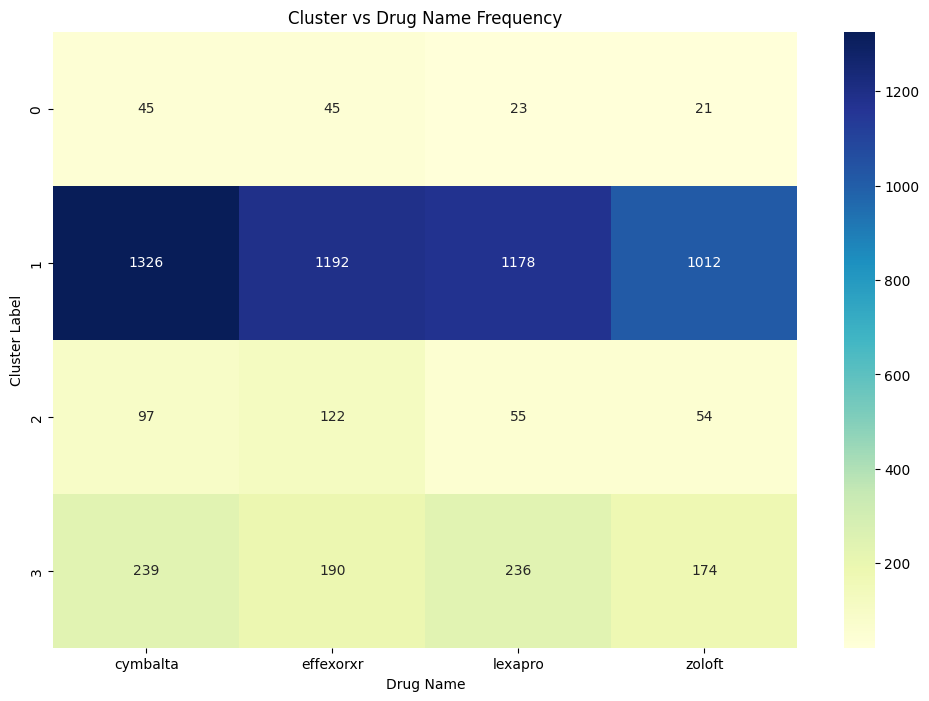

Chi2: 45.95915230961694, p-value: 6.128152407241562e-07


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

print(df['drug_name'].value_counts())

contingency_table = pd.crosstab(df['cluster'], df['drug_name'])
print(contingency_table)

plt.figure(figsize=(12, 8))
sns.heatmap(contingency_table, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Cluster vs Drug Name Frequency')
plt.ylabel('Cluster Label')
plt.xlabel('Drug Name')
plt.show()

chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi2: {chi2}, p-value: {p}")

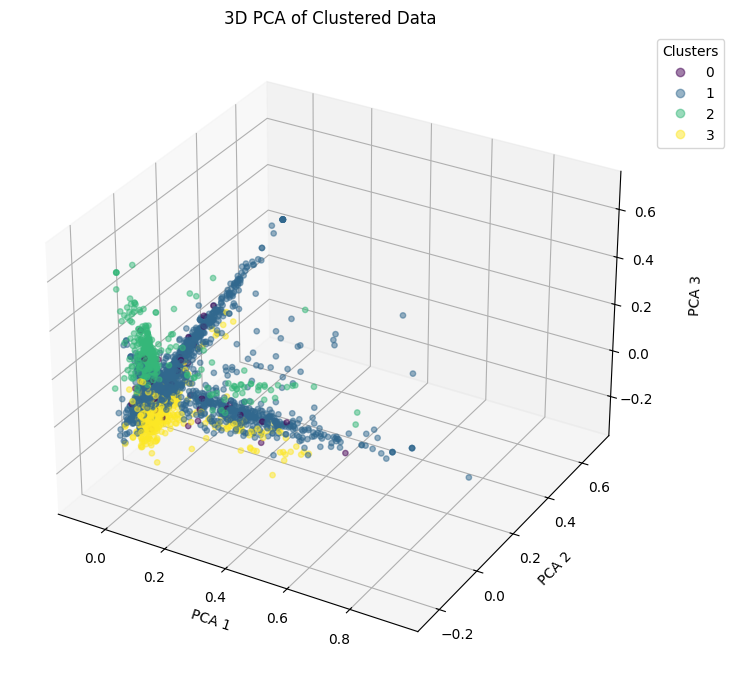

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from sklearn.cluster import KMeans


pca = PCA(n_components=3)
X_dim = pca.fit_transform(tfidfSentences.toarray())

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_dim[:, 0], X_dim[:, 1], X_dim[:, 2], c=km.labels_, cmap='viridis', s=15, alpha=0.5)

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')

ax.zaxis.labelpad = 15

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

legend = ax.legend(*scatter.legend_elements(), loc='upper left', bbox_to_anchor=(1, 1), title="Clusters")

plt.title('3D PCA of Clustered Data')
plt.show()

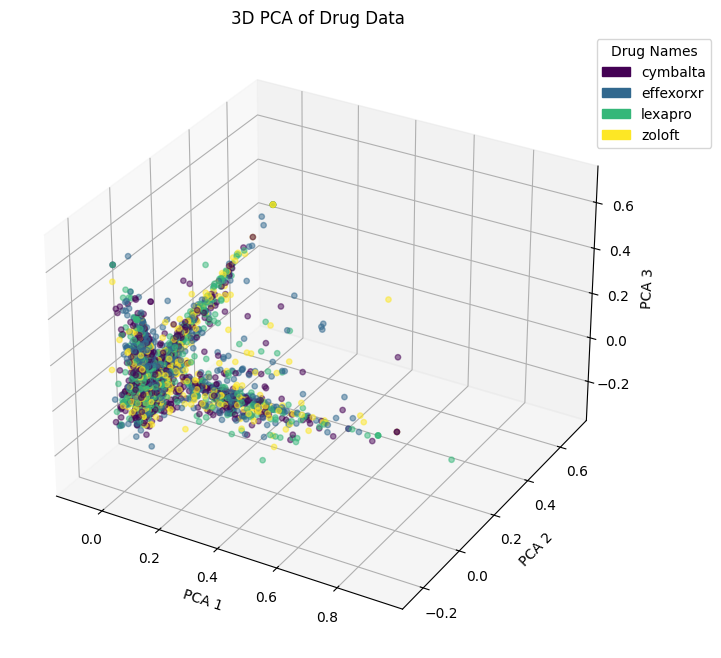

In [10]:
from sklearn.preprocessing import LabelEncoder
from matplotlib.patches import Patch
import numpy as np

label_encoder = LabelEncoder()
drug_labels = label_encoder.fit_transform(df['drug_name'])

pca = PCA(n_components=3) 
X_dim = pca.fit_transform(tfidfSentences.toarray())

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_dim[:, 0], X_dim[:, 1], X_dim[:, 2], c=drug_labels, cmap='viridis', s=15, alpha=0.5)

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')

cmap = plt.cm.viridis

legend_handles = [Patch(color=cmap(norm), label=label) for label, norm in zip(label_encoder.classes_, np.linspace(0, 1, len(label_encoder.classes_)))]
ax.legend(handles=legend_handles, title="Drug Names", loc='upper right', bbox_to_anchor=(1.15, 1))

plt.title('3D PCA of Drug Data')
plt.show()

## Logistic Regression Baseline for Binary Ones

In [11]:
# ## This is just the plain sentences -- Task 1 Feature 1
# from sklearn.model_selection import train_test_split

# df['DI'] = pd.to_numeric(df['DI'], errors='coerce')

# x = df['sentences'].values
# y = df[['ADR', 'WD', 'EF', 'INF', 'SSI', 'DI']].values
# y = np.nan_to_num(y, nan=0).astype(int)

# x_temp, x_test, y_temp, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
# x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.11, random_state=42) 


In [12]:
# This one uses the drug_name with the sentences -- Task 1 Feature 2

from sklearn.model_selection import train_test_split

df['DI'] = pd.to_numeric(df['DI'], errors='coerce')

df['drug_sentences'] = df['drug_name'] + ' ' + df['sentences']
x = df['drug_sentences'].values
y = df[['ADR', 'WD', 'EF', 'INF', 'SSI', 'DI']].values
y = np.nan_to_num(y, nan=0).astype(int)

x_temp, x_test, y_temp, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.11, random_state=42) 


In [13]:
print('total length=',len(df))
print('%len of training set=',len(x_train)/len(df)*100)
print('%len of validation set=',len(x_val)/len(df)*100)
print('%len of test set=',len(x_test)/len(df)*100)

total length= 6009
%len of training set= 80.09652188384091
%len of validation set= 9.901813945748044
%len of test set= 10.001664170411049


In [14]:
train_label_counts_0 = [sum(y_train[:, i] == 0) for i in range(y_train.shape[1])]
train_label_counts_1 = [sum(y_train[:, i] == 1) for i in range(y_train.shape[1])]
val_label_counts_0 = [sum(y_val[:, i] == 0) for i in range(y_val.shape[1])]
val_label_counts_1 = [sum(y_val[:, i] == 1) for i in range(y_val.shape[1])]
test_label_counts_0 = [sum(y_test[:, i] == 0) for i in range(y_test.shape[1])]
test_label_counts_1 = [sum(y_test[:, i] == 1) for i in range(y_test.shape[1])]

distribution_df = pd.DataFrame({
    'Label': ['ADR', 'WD', 'EF', 'INF', 'SSI', 'DI'],
    'Train Count (0)': train_label_counts_0,
    'Train Count (1)': train_label_counts_1,
    'Validation Count (0)': val_label_counts_0,
    'Validation Count (1)': val_label_counts_1,
    'Test Count (0)': test_label_counts_0,
    'Test Count (1)': test_label_counts_1
})

# Display the DataFrame
print(distribution_df)


  Label  Train Count (0)  Train Count (1)  Validation Count (0)  \
0   ADR             3072             1741                   385   
1    WD             4463              350                   547   
2    EF             3917              896                   495   
3   INF             4539              274                   561   
4   SSI             4170              643                   526   
5    DI             4394              419                   548   

   Validation Count (1)  Test Count (0)  Test Count (1)  
0                   210             384             217  
1                    48             561              40  
2                   100             510              91  
3                    34             572              29  
4                    69             524              77  
5                    47             551              50  


In [15]:
distribution_df

,Label,Train Count (0),Train Count (1),Validation Count (0),Validation Count (1),Test Count (0),Test Count (1)
0,ADR,3072,1741,385,210,384,217
1,WD,4463,350,547,48,561,40
2,EF,3917,896,495,100,510,91
3,INF,4539,274,561,34,572,29
4,SSI,4170,643,526,69,524,77
5,DI,4394,419,548,47,551,50


In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score

tfidf_vectorizer = TfidfVectorizer()
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
x_val_tfidf = tfidf_vectorizer.transform(x_val)
x_test_tfidf = tfidf_vectorizer.transform(x_test)

param_grid = {
    'estimator__C': [0.1, 1, 10, 100], 
    'estimator__penalty': ['l2'],  
    'estimator__solver': ['liblinear']
}

log_reg = LogisticRegression()
multi_target_lr = MultiOutputClassifier(log_reg, n_jobs=-1)
grid_search = GridSearchCV(multi_target_lr, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train_tfidf, y_train)

print("best param ", grid_search.best_params_)
print("cross_val accuracy ", grid_search.best_score_)

best_model = grid_search.best_estimator_

y_val_pred = best_model.predict(x_val_tfidf)
y_test_pred = best_model.predict(x_test_tfidf)

val_accuracy = accuracy_score(y_val, y_val_pred)
val_f1_micro = f1_score(y_val, y_val_pred, average='micro')
val_f1_macro = f1_score(y_val, y_val_pred, average='macro')
val_precision_micro = precision_score(y_val, y_val_pred, average='micro')
val_precision_macro = precision_score(y_val, y_val_pred, average='macro')
val_recall_micro = recall_score(y_val, y_val_pred, average='micro')
val_recall_macro = recall_score(y_val, y_val_pred, average='macro')

test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1_micro = f1_score(y_test, y_test_pred, average='micro')
test_f1_macro = f1_score(y_test, y_test_pred, average='macro')
test_precision_micro = precision_score(y_test, y_test_pred, average='micro')
test_precision_macro = precision_score(y_test, y_test_pred, average='macro')
test_recall_micro = recall_score(y_test, y_test_pred, average='micro')
test_recall_macro = recall_score(y_test, y_test_pred, average='macro')

print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Validation F1 Score (Micro): {val_f1_micro:.4f}')
print(f'Validation F1 Score (Macro): {val_f1_macro:.4f}')
print(f'Validation Precision (Micro): {val_precision_micro:.4f}')
print(f'Validation Precision (Macro): {val_precision_macro:.4f}')
print(f'Validation Recall (Micro): {val_recall_micro:.4f}')
print(f'Validation Recall (Macro): {val_recall_macro:.4f}')

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test F1 Score (Micro): {test_f1_micro:.4f}')
print(f'Test F1 Score (Macro): {test_f1_macro:.4f}')
print(f'Test Precision (Micro): {test_precision_micro:.4f}')
print(f'Test Precision (Macro): {test_precision_macro:.4f}')
print(f'Test Recall (Micro): {test_recall_micro:.4f}')
print(f'Test Recall (Macro): {test_recall_macro:.4f}')

for i, label in enumerate(['ADR', 'WD', 'EF', 'INF', 'SSI', 'DI']):
    print(f"{label}:")
    #[(tn, fp,
    # fn, tp)]
    cm = confusion_matrix(y_test[:, i], y_test_pred[:, i])
    print(f"{cm}")
    
    report = classification_report(y_test[:, i], y_test_pred[:, i], zero_division=1, target_names=["0", "1"])
    print(f"{report}")

best param  {'estimator__C': 10, 'estimator__penalty': 'l2', 'estimator__solver': 'liblinear'}
cross_val accuracy  0.5969292081441614
Validation Accuracy: 0.6118
Validation F1 Score (Micro): 0.6143
Validation F1 Score (Macro): 0.4907
Validation Precision (Micro): 0.7771
Validation Precision (Macro): 0.7170
Validation Recall (Micro): 0.5079
Validation Recall (Macro): 0.3995
Test Accuracy: 0.6306
Test F1 Score (Micro): 0.6584
Test F1 Score (Macro): 0.5550
Test Precision (Micro): 0.7624
Test Precision (Macro): 0.6938
Test Recall (Micro): 0.5794
Test Recall (Macro): 0.4793
ADR:
[[353  31]
 [ 67 150]]
              precision    recall  f1-score   support

           0       0.84      0.92      0.88       384
           1       0.83      0.69      0.75       217

    accuracy                           0.84       601
   macro avg       0.83      0.81      0.82       601
weighted avg       0.84      0.84      0.83       601

WD:
[[557   4]
 [ 30  10]]
              precision    recall  f1-scor

## Transformer for Binary Ones

In [17]:
from transformers import AutoTokenizer

epochs=50
learning_rate=0.2
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

def tokenize_data(X):
    return tokenizer(X.tolist(), padding=True, truncation=True, max_length=512, return_tensors='pt')

x_test_tokenized = tokenize_data(x_test)
x_train_tokenized = tokenize_data(x_train)
x_val_tokenized = tokenize_data(x_val)



c:\Users\julev\anaconda3\envs\cudaEnv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [18]:
from torch.utils.data import Dataset, DataLoader

class TextClassificationDataset(Dataset):
    def __init__(self, encodings, labels, fill_value=0.):
        self.encodings = encodings
        self.labels = labels
        self.fill_value = fill_value

    def __getitem__(self, idx):
        item = {key: torch.nan_to_num(torch.tensor(val[idx])) for key, val in self.encodings.items()}
        item['labels'] = torch.nan_to_num(torch.tensor(self.labels[idx], dtype=torch.float), nan=self.fill_value)
        return item

    def __len__(self):
        return len(self.labels)

# Create dataset instances
train_dataset = TextClassificationDataset(x_train_tokenized, y_train)
val_dataset = TextClassificationDataset(x_val_tokenized, y_val)
test_dataset = TextClassificationDataset(x_test_tokenized, y_test)


In [19]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [20]:
from transformers import BertConfig, BertForSequenceClassification

custom_config = BertConfig(
    hidden_size=768,         # Embedding size
    num_hidden_layers=24,    # Number of layers
    num_attention_heads=12,  # Number of attention heads
    intermediate_size=3072,  # Intermediate size of feed-forward layers
    num_labels=6             # Number of output labels for classification
)

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6) 
#model = BertForSequenceClassification(custom_config)


c:\Users\julev\anaconda3\envs\cudaEnv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
layer_count = 0

def count_layers(module):
    global layer_count
    if isinstance(module, (torch.nn.Linear, torch.nn.Conv2d, torch.nn.Embedding, torch.nn.LayerNorm, torch.nn.Dropout, torch.nn.GELU)):
        layer_count += 1
    for child in module.children():
        count_layers(child)

count_layers(model)

print(f"The model has {layer_count} trainable layers.")

The model has 140 trainable layers.


In [22]:
print(epochs)

50


In [23]:
import time
import matplotlib.pyplot as plt
from torch.optim import AdamW
from tqdm import tqdm
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {torch.cuda.get_device_name(0)}") 


Using device: NVIDIA GeForce RTX 3060 Ti


In [24]:
model.to(device)

optimizer = AdamW(model.parameters(), lr=learning_rate)

total_start_time = time.time()
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

def calculate_accuracy(outputs, labels):
    preds = torch.sigmoid(outputs).round()
    correct = (preds == labels).float()
    return correct.sum() / len(correct)

model.train()
for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0
    epoch_train_correct = 0
    train_total = 0
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for batch in progress_bar:
        batch = {k: v.to(device) for k, v in batch.items()}
        
        optimizer.zero_grad()
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        batch_loss = loss.item()
        epoch_train_loss += batch_loss
        
        epoch_train_correct += calculate_accuracy(outputs.logits, batch['labels']) * len(batch['labels'])
        train_total += len(batch['labels'])
        
        progress_bar.set_postfix({'loss': batch_loss})
    
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_accuracy = epoch_train_correct / train_total
    
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy.item())

    model.eval()
    epoch_val_loss = 0
    epoch_val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            epoch_val_loss += loss.item()
            
            epoch_val_correct += calculate_accuracy(outputs.logits, batch['labels']) * len(batch['labels'])
            val_total += len(batch['labels'])

    avg_val_loss = epoch_val_loss / len(val_loader)
    val_accuracy = epoch_val_correct / val_total
    
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy.item())

    print(f"Epoch {epoch+1} completed. Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

total_end_time = time.time()
total_training_time = total_end_time - total_start_time
print(f"Total training time: {total_training_time:.2f} seconds")

plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/50:   0%|          | 0/151 [00:00<?, ?it/s]C:\Users\julev\AppData\Local\Temp\ipykernel_20804\3429738015.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.nan_to_num(torch.tensor(val[idx])) for key, val in self.encodings.items()}


In [ ]:
model_save_path = './task1_feature2_model'
model.save_pretrained(model_save_path)

In [ ]:
model_load_path = './task1_feature2_model'
model = BertForSequenceClassification.from_pretrained(model_load_path)
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

model.eval()
all_predictions = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Predicting"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        predictions = (torch.sigmoid(logits) > 0.5).int()
        all_predictions.extend(predictions.cpu().numpy())

all_predictions = np.array(all_predictions)
test_labels = np.array(y_test)

for i, label in enumerate(['ADR', 'WD', 'EF', 'INF', 'SSI', 'DI']):
    print(f"{label}:")
    #[(tn, fp,
    # fn, tp)]
    cm = confusion_matrix(test_labels[:, i], all_predictions[:, i])
    print(f"{cm}")

    report = classification_report(test_labels[:, i], all_predictions[:, i], zero_division=1, target_names=["0", "1"])
    print(f"{report}")
    
accuracy = accuracy_score(test_labels, all_predictions)
precision_micro = precision_score(test_labels, all_predictions, average='micro')
precision_macro = precision_score(test_labels, all_predictions, average='macro')
recall_micro = recall_score(test_labels, all_predictions, average='micro')
recall_macro = recall_score(test_labels, all_predictions, average='macro')
f1_micro = f1_score(test_labels, all_predictions, average='micro')
f1_macro = f1_score(test_labels, all_predictions, average='macro')

print(f'Overall Accuracy: {accuracy:.4f}')
print(f'Overall Precision (Micro): {precision_micro:.4f}')
print(f'Overall Precision (Macro): {precision_macro:.4f}')
print(f'Overall Recall (Micro): {recall_micro:.4f}')
print(f'Overall Recall (Macro): {recall_macro:.4f}')
print(f'Overall F1 Score (Micro): {f1_micro:.4f}')
print(f'Overall F1 Score (Macro): {f1_macro:.4f}')

Predicting:   0%|          | 0/19 [00:00<?, ?it/s]C:\Users\julev\AppData\Local\Temp\ipykernel_25352\3429738015.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.nan_to_num(torch.tensor(val[idx])) for key, val in self.encodings.items()}
Predicting: 100%|██████████| 19/19 [00:00<00:00, 24.45it/s]

ADR:
[[  0 384]
 [  0 217]]
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       384
           1       0.36      1.00      0.53       217

    accuracy                           0.36       601
   macro avg       0.68      0.50      0.27       601
weighted avg       0.77      0.36      0.19       601

WD:
[[561   0]
 [ 40   0]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.97       561
           1       1.00      0.00      0.00        40

    accuracy                           0.93       601
   macro avg       0.97      0.50      0.48       601
weighted avg       0.94      0.93      0.90       601

EF:
[[510   0]
 [ 91   0]]
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       510
           1       1.00      0.00      0.00        91

    accuracy                           0.85       601
   macro avg       0.92      0.50      0.46   


c:\Users\julev\anaconda3\envs\cudaEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
print(all_predictions)
print('length of predictions:',len(all_predictions))
print('length of test data:',len(x_test))

[[1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 ...
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]]
length of predictions: 601
length of test data: 601


## Logistic Regression Baseline for Drug Prediction

In [ ]:
# this one has no 0s and 1s as extra features
x = df['sentences'].values
y = df['drug_name']

# Split data
x_temp, x_test, y_temp, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.11, random_state=42) 

In [ ]:
# this one has extra 0s and 1s as extra features
sentences = df['sentences'].values
annotation_values = df[['ADR', 'WD', 'EF', 'INF', 'SSI', 'DI']].values

x = [
    sentence + " " + " ".join(map(str, annotation_value)) 
    for sentence, annotation_value in zip(sentences, annotation_values)
]

# Split data
x_temp, x_test, y_temp, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.11, random_state=42) 

In [ ]:
# this one uses ONLY the annotated values

x_number = df[['ADR', 'WD', 'EF', 'INF', 'SSI', 'DI']].fillna(0).values
y_number = df['drug_name']

x_temp_number, x_test_number, y_temp_number, y_test_number = train_test_split(x_number, y_number, test_size=0.1, random_state=42)
x_train_number, x_val_number, y_train_number, y_val_number = train_test_split(x_temp_number, y_temp_number, test_size=0.11, random_state=42) 

logistic_regression_number = LogisticRegression()

# Train the classifier
logistic_regression_number.fit(x_train_number, y_train_number)

# Validate the classifier
y_val_pred_number = logistic_regression_number.predict(x_val_number)
val_accuracy_number = accuracy_score(y_val_number, y_val_pred_number)
print(f'Validation Accuracy: {val_accuracy_number:.4f}')
print('Validation Classification Report:')
print(classification_report(y_val_number, y_val_pred_number,zero_division=0))

# Test the classifier
y_test_pred_number = logistic_regression_number.predict(x_test_number)
test_accuracy_number = accuracy_score(y_test_number, y_test_pred_number)
print(f'Test Accuracy: {test_accuracy_number:.4f}')
print('Test Classification Report:')
print(classification_report(y_test_number, y_test_pred_number,zero_division=0))

Validation Accuracy: 0.3092
Validation Classification Report:
              precision    recall  f1-score   support

    cymbalta       0.30      0.75      0.43       172
   effexorxr       0.36      0.25      0.29       148
     lexapro       0.29      0.12      0.17       147
      zoloft       0.00      0.00      0.00       128

    accuracy                           0.31       595
   macro avg       0.24      0.28      0.22       595
weighted avg       0.25      0.31      0.24       595

Test Accuracy: 0.2978
Test Classification Report:
              precision    recall  f1-score   support

    cymbalta       0.29      0.77      0.42       169
   effexorxr       0.38      0.22      0.28       167
     lexapro       0.21      0.08      0.12       148
      zoloft       0.00      0.00      0.00       117

    accuracy                           0.30       601
   macro avg       0.22      0.27      0.20       601
weighted avg       0.24      0.30      0.23       601



In [ ]:
y_train_series = pd.Series(y_train)
y_val_series = pd.Series(y_val)
y_test_series = pd.Series(y_test)

print("Distribution in training set:")
print(y_train_series.value_counts())
print("Distribution in validation set:")
print(y_val_series.value_counts())
print("Distribution in test set:")
print(y_test_series.value_counts())

Distribution in training set:
drug_name
cymbalta     1366
effexorxr    1234
lexapro      1197
zoloft       1016
Name: count, dtype: int64
Distribution in validation set:
drug_name
cymbalta     172
effexorxr    148
lexapro      147
zoloft       128
Name: count, dtype: int64
Distribution in test set:
drug_name
cymbalta     169
effexorxr    167
lexapro      148
zoloft       117
Name: count, dtype: int64


In [ ]:
tfidf_vectorizer = TfidfVectorizer()
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
x_val_tfidf = tfidf_vectorizer.transform(x_val)
x_test_tfidf = tfidf_vectorizer.transform(x_test)

param_grid = {
    'C': [0.1, 1, 10, 100], 
    'penalty': ['l2'],  
    'solver': ['liblinear'] 
}

logistic_regression_model = LogisticRegression()
grid_search = GridSearchCV(logistic_regression_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train_tfidf, y_train)

print("best param ", grid_search.best_params_)
print("cross_val accuracy ", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(x_test_tfidf)
print("test set")
print(classification_report(y_test, y_test_pred))

best param  {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
cross_val accuracy  0.4172030405675266
test set
              precision    recall  f1-score   support

    cymbalta       0.46      0.57      0.51       169
   effexorxr       0.46      0.46      0.46       167
     lexapro       0.45      0.41      0.43       148
      zoloft       0.39      0.29      0.33       117

    accuracy                           0.45       601
   macro avg       0.44      0.43      0.43       601
weighted avg       0.44      0.45      0.44       601



## Transformer for Drug Classification

In [ ]:
category_mapping = df['drug_name'].astype('category').cat.categories

In [ ]:
# # this one is for the combined sentences -- Task 2 Feature 1

# df_word_label = df
def transform_labels(row):
    labels = [
        '[POS] adverse drug reaction' if row['ADR'] == 1 else '[NEG] adverse drug reaction',
        '[POS] withdrawal symptom' if row['WD'] == 1 else '[NEG] withdrawal symptom',
        '[POS] effective' if row['EF'] == 1 else '[NEG] effective',
        '[POS] ineffective' if row['INF'] == 1 else '[NEG] ineffective',
        '[POS] sign/symptom/illness' if row['SSI'] == 1 else '[NEG] sign/symptom/illness',
        '[POS] drug indication' if row['DI'] == 1 else '[NEG] drug indication'
    ]
    return ' '.join(labels)

# df_word_label['transformed_sentences'] = df.apply(lambda row: f"{row['sentences']} {transform_labels(row)}", axis=1)
# print(df_word_label['transformed_sentences'])

# ## ADR: adverse drug reaction
# ## WD: withdrawal symptom
# ## EF: effective
# ## INF: ineffective
# ## SSI: Sign/symptom/illness - if report contains explicit SSI that patient experienced that are not a result of the drug
# ## DI: drug indication - shows SSI that explicitly mentioned as being resolved because of drug consumption

# x = df_word_label['transformed_sentences'].values
# y = df_word_label['drug_name'].astype('category').cat.codes.values

# # Split data
# x_temp, x_test, y_temp, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
# x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.11, random_state=42) 

0       extreme weight gain short-term memory loss hai...
1       detoxing lexapro [NEG] adverse drug reaction [...
2       slowly cut dosage several months took vitamin ...
3       10 days completely omg rough [NEG] adverse dru...
4       flu-like symptoms dizziness major mood swings ...
                              ...                        
6004    increase dosage yet [NEG] adverse drug reactio...
6005    'm hoping able stay 75 mgs long possible [NEG]...
6006    reading withdrawals little scarey like said pe...
6007    effexor made huge difference life come experie...
6008    would small price pay able enjoy life [NEG] ad...
Name: transformed_sentences, Length: 6009, dtype: object


In [ ]:
## This one is just for the text without transformed sentences -- Task 2 Feature 2
# df_word_label=df
# x = df_word_label['sentences'].values
# y = df_word_label['drug_name'].astype('category').cat.codes.values

# # Split data
# x_temp, x_test, y_temp, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
# x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.11, random_state=42) 


In [ ]:
## This one is just for the annotated dataset -- Task 2 Feature 3

df_word_label = df

df_word_label['transformed_labels'] = df_word_label.apply(transform_labels, axis=1)
print(df_word_label['transformed_labels'])

x = df_word_label['transformed_labels'].values
y = df_word_label['drug_name'].astype('category').cat.codes.values

# Split data
x_temp, x_test, y_temp, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.11, random_state=42) 



0       [POS] adverse drug reaction [NEG] withdrawal s...
1       [NEG] adverse drug reaction [NEG] withdrawal s...
2       [NEG] adverse drug reaction [NEG] withdrawal s...
3       [NEG] adverse drug reaction [NEG] withdrawal s...
4       [NEG] adverse drug reaction [POS] withdrawal s...
                              ...                        
6004    [NEG] adverse drug reaction [NEG] withdrawal s...
6005    [NEG] adverse drug reaction [NEG] withdrawal s...
6006    [NEG] adverse drug reaction [NEG] withdrawal s...
6007    [NEG] adverse drug reaction [NEG] withdrawal s...
6008    [NEG] adverse drug reaction [NEG] withdrawal s...
Name: transformed_labels, Length: 6009, dtype: object


In [ ]:
print(x_train)

['[NEG] adverse drug reaction [NEG] withdrawal symptom [NEG] effective [NEG] ineffective [NEG] sign/symptom/illness [NEG] drug indication'
 '[POS] adverse drug reaction [NEG] withdrawal symptom [NEG] effective [NEG] ineffective [NEG] sign/symptom/illness [NEG] drug indication'
 '[POS] adverse drug reaction [NEG] withdrawal symptom [NEG] effective [NEG] ineffective [NEG] sign/symptom/illness [NEG] drug indication'
 ...
 '[POS] adverse drug reaction [NEG] withdrawal symptom [NEG] effective [NEG] ineffective [NEG] sign/symptom/illness [NEG] drug indication'
 '[NEG] adverse drug reaction [NEG] withdrawal symptom [POS] effective [NEG] ineffective [NEG] sign/symptom/illness [NEG] drug indication'
 '[NEG] adverse drug reaction [NEG] withdrawal symptom [NEG] effective [NEG] ineffective [NEG] sign/symptom/illness [NEG] drug indication']


In [ ]:
x_test_tokenized = tokenize_data(x_test)
x_train_tokenized = tokenize_data(x_train)
x_val_tokenized = tokenize_data(x_val)

In [ ]:
train_dataset_new = TextClassificationDataset(x_train_tokenized, y_train)
val_dataset_new = TextClassificationDataset(x_val_tokenized, y_val)
test_dataset_new = TextClassificationDataset(x_test_tokenized, y_test)

In [ ]:
epochs=50
learning_rate=0.2
model=()
custom_config = BertConfig(
    hidden_size=768,         # Embedding size
    num_hidden_layers=24,    # Number of layers
    num_attention_heads=12,  # Number of attention heads
    intermediate_size=3072,  # Intermediate size of feed-forward layers
    num_labels=1            # Number of output labels for classification
)

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', config=custom_config, ignore_mismatched_sizes=True) 

c:\Users\julev\anaconda3\envs\cudaEnv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.12.attention.output.LayerNorm.bias', 'bert.encoder.layer.12.attention.output.LayerNorm.weight', 'bert.encoder.layer.12.attention.output.dense.bias', 'bert.encoder.layer.12.attention.output.dense.weight', 'bert.encoder.layer.12.attention.self.key.bias', 'bert.encoder.layer.12.attention.self.key.weight', 'bert.encoder.layer.12.attention.self.query.bias', 'bert.encoder.layer.12.attention.self.query.weight', 'bert.encoder.layer.12.attention.self.value.bias', 'bert.encoder.layer.12.attention.self.value.weight', 'bert.encoder.layer.12.int

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {torch.cuda.get_device_name(0)}") 

model.to(device)

optimizer = AdamW(model.parameters(), lr=learning_rate)

train_loader = DataLoader(train_dataset_new, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset_new, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset_new, batch_size=32, shuffle=False)

total_start_time = time.time()
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


model.train()
for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0
    epoch_train_correct = 0
    train_total = 0
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for batch in progress_bar:
        batch = {k: v.to(device) for k, v in batch.items()}
        
        optimizer.zero_grad()
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        batch_loss = loss.item()
        epoch_train_loss += batch_loss
        
        epoch_train_correct += calculate_accuracy(outputs.logits, batch['labels']) * len(batch['labels'])
        train_total += len(batch['labels'])
        
        progress_bar.set_postfix({'loss': batch_loss})
    
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_accuracy = epoch_train_correct / train_total
    
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy.item())

    model.eval()
    epoch_val_loss = 0
    epoch_val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            epoch_val_loss += loss.item()
            
            epoch_val_correct += calculate_accuracy(outputs.logits, batch['labels']) * len(batch['labels'])
            val_total += len(batch['labels'])

    avg_val_loss = epoch_val_loss / len(val_loader)
    val_accuracy = epoch_val_correct / val_total
    
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy.item())

    print(f"Epoch {epoch+1} completed. Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

total_end_time = time.time()
total_training_time = total_end_time - total_start_time
print(f"Total training time: {total_training_time:.2f} seconds")

plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Using device: NVIDIA GeForce RTX 3060 Ti


Epoch 1/2:   0%|          | 0/151 [00:00<?, ?it/s]C:\Users\julev\AppData\Local\Temp\ipykernel_25352\3429738015.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.nan_to_num(torch.tensor(val[idx])) for key, val in self.encodings.items()}
Epoch 1/2:  11%|█         | 16/151 [05:05<42:57, 19.09s/it, loss=6.58e+3]


KeyboardInterrupt: 

In [ ]:
model_save_path = './task2_feature3_model'
model.save_pretrained(model_save_path)

In [ ]:
model_load_path = './task2_feature3_model'
model = BertForSequenceClassification.from_pretrained(model_load_path)
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
model.eval()
all_predictions = []

In [ ]:
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Predicting"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        all_predictions.extend(predictions.cpu().numpy())

all_predictions = np.array(all_predictions)
test_labels = np.array(y_test)

predicted_labels = [category_mapping[pred] for pred in all_predictions]
true_labels = [category_mapping[true] for true in test_labels]

predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels)

cm = confusion_matrix(true_labels, predicted_labels, labels=category_mapping)
print(f"Confusion Matrix:\n{cm}")

report = classification_report(true_labels, predicted_labels, zero_division=1, target_names=category_mapping)
print(f"Classification Report:\n{report}")

accuracy = accuracy_score(true_labels, predicted_labels)
precision_micro = precision_score(true_labels, predicted_labels, average='micro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
recall_micro = recall_score(true_labels, predicted_labels, average='micro')
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
f1_micro = f1_score(true_labels, predicted_labels, average='micro')
f1_macro = f1_score(true_labels, predicted_labels, average='macro')

print(f'Overall Accuracy: {accuracy:.4f}')
print(f'Overall Precision (Micro): {precision_micro:.4f}')
print(f'Overall Precision (Macro): {precision_macro:.4f}')
print(f'Overall Recall (Micro): {recall_micro:.4f}')
print(f'Overall Recall (Macro): {recall_macro:.4f}')
print(f'Overall F1 Score (Micro): {f1_micro:.4f}')
print(f'Overall F1 Score (Macro): {f1_macro:.4f}')

Confusion Matrix:
[[169   0   0   0]
 [167   0   0   0]
 [148   0   0   0]
 [117   0   0   0]]
Classification Report:
              precision    recall  f1-score   support

    cymbalta       0.28      1.00      0.44       169
   effexorxr       1.00      0.00      0.00       167
     lexapro       1.00      0.00      0.00       148
      zoloft       1.00      0.00      0.00       117

    accuracy                           0.28       601
   macro avg       0.82      0.25      0.11       601
weighted avg       0.80      0.28      0.12       601

Overall Accuracy: 0.2812
Overall Precision (Micro): 0.2812
Overall Precision (Macro): 0.0703
Overall Recall (Micro): 0.2812
Overall Recall (Macro): 0.2500
Overall F1 Score (Micro): 0.2812
Overall F1 Score (Macro): 0.1097


c:\Users\julev\anaconda3\envs\cudaEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
print(all_predictions)
print('length of predictions:',len(all_predictions))
print('length of test data:',len(x_test))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 